##### Exploratory Data Analysis (EDA):

In [693]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [694]:
df_2022 = pd.read_csv('../../datasets/daily_aqi_by_county_2022-2.csv')
df_2023 = pd.read_csv('../../datasets/daily_aqi_by_county_2023-1.csv')
df_2024 = pd.read_csv('../../datasets/daily_aqi_by_county_2024.csv') # This dataset differs from the one offered in the assignment since it seems like some dates got clipped.

# column 'AQI' is my target, and using the other column 'Date' as the series column I'll use time series regression techniques.
# df_2024.head(5)


In [695]:
# First I'll need to extract Only Utah from State Name, and Weber County from County Name.
# Filter for rows where State Name is 'Utah' and county Name is 'Weber'
df_2022_filtered = df_2022[(df_2022['State Name'] == 'Utah') & (df_2022['county Name'] == 'Weber')]
df_2022_filtered = df_2022_filtered.reset_index(drop=True)

df_2023_filtered = df_2023[(df_2023['State Name'] == 'Utah') & (df_2023['county Name'] == 'Weber')]
df_2023_filtered = df_2023_filtered.reset_index(drop=True)

df_2024_filtered = df_2024[(df_2024['State Name'] == 'Utah') & (df_2024['county Name'] == 'Weber')]
df_2024_filtered = df_2024_filtered.reset_index(drop=True)

# Keep only Date and AQI, convert Date to datetime, and set it as index
for df in [df_2022_filtered, df_2023_filtered, df_2024_filtered]:
    df.drop(columns=[col for col in df.columns if col not in ['Date', 'AQI']], inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

# print('Row Count for Each Year:')
# print('2022:', len(df_2022_filtered))
# print('2023:', len(df_2023_filtered))
# print('2024:', len(df_2024_filtered))


The data was loaded in and filtered to remove all columns except for State Name, and county Name. Then additional steps were taken to only grab rows with Utah, and Weber in their state and county name. 2022 had 365 rows, 2023 had 365 rows, and 2024 had 366 rows. This meant that there was a valid data entry for every single day, and this was proven to be true since there were no missing or NA values in these datasets.

In [696]:
# Create visual-only copies with just Date, AQI, and Year
df_2022_vis = df_2022_filtered[['AQI']].copy()
df_2022_vis['Year'] = 2022

df_2023_vis = df_2023_filtered[['AQI']].copy()
df_2023_vis['Year'] = 2023

df_2024_vis = df_2024_filtered[['AQI']].copy()
df_2024_vis['Year'] = 2024

# Combine for visualization
df_vis_all = pd.concat([df_2022_vis, df_2023_vis, df_2024_vis])

# Convert Date and set index
# df_vis_all['Date'] = pd.to_datetime(df_vis_all['Date'])
# df_vis_all.set_index('Date', inplace=True)

# print('Check for missing/na values:')
# print(df_vis_all.isna().sum())

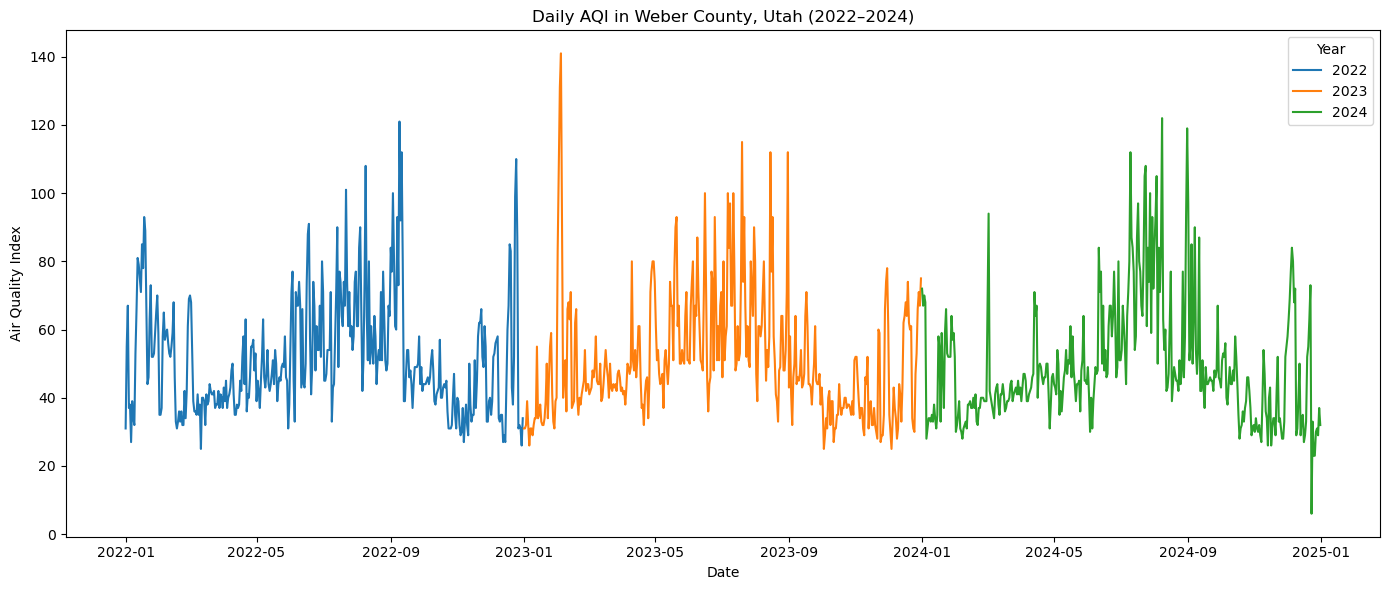

In [697]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_vis_all, x=df_vis_all.index, y='AQI', hue='Year', palette='tab10')
plt.title('Daily AQI in Weber County, Utah (2022–2024)')
plt.xlabel('Date')
plt.ylabel('Air Quality Index')
plt.legend(title='Year')
plt.tight_layout()
plt.show()

The daily AQI shows that there is quite a bit of fluctuations day to day, and that each year follows a similar pattern. This means there seasonality is present in this data.

In [698]:
# # Define custom colors
# color_2022 = '#1f77b4'  # blue
# color_2023 = '#ff7f0e'  # orange
# color_2024 = '#2ca02c'  # green

# # Create vertical subplots: 3 rows, 1 column
# fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=False, sharey=True)

# # Plot 2022
# sns.lineplot(data=df_2022_vis, x=df_2022_vis.index, y='AQI', ax=axes[0], color=color_2022)
# axes[0].set_title('AQI Trends - 2022')
# axes[0].set_xlabel('Month')
# axes[0].set_ylabel('Air Quality Index')

# # Plot 2023
# sns.lineplot(data=df_2023_vis, x=df_2023_vis.index, y='AQI', ax=axes[1], color=color_2023)
# axes[1].set_title('AQI Trends - 2023')
# axes[1].set_xlabel('Month')
# axes[1].set_ylabel('Air Quality Index')

# # Plot 2024
# sns.lineplot(data=df_2024_vis, x=df_2024_vis.index, y='AQI', ax=axes[2], color=color_2024)
# axes[2].set_title('AQI Trends - 2024')
# axes[2].set_xlabel('Month')
# axes[2].set_ylabel('Air Quality Index')

# plt.tight_layout()
# plt.show()

In [699]:
# # Create subplots: 1 row, 3 columns
# fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# # Plot each year's AQI distribution
# sns.histplot(df_2022_vis['AQI'], kde=True, ax=axes[0], color='skyblue')
# axes[0].set_title('AQI Daily Distribution - 2022')

# sns.histplot(df_2023_vis['AQI'], kde=True, ax=axes[1], color='salmon')
# axes[1].set_title('AQI Daily Distribution - 2023')

# sns.histplot(df_2024_vis['AQI'], kde=True, ax=axes[2], color='limegreen')
# axes[2].set_title('AQI Daily Distribution - 2024')

# # Add common labels
# for ax in axes:
#     ax.set_xlabel('AQI')
#     ax.set_ylabel('Frequency')

# plt.tight_layout()

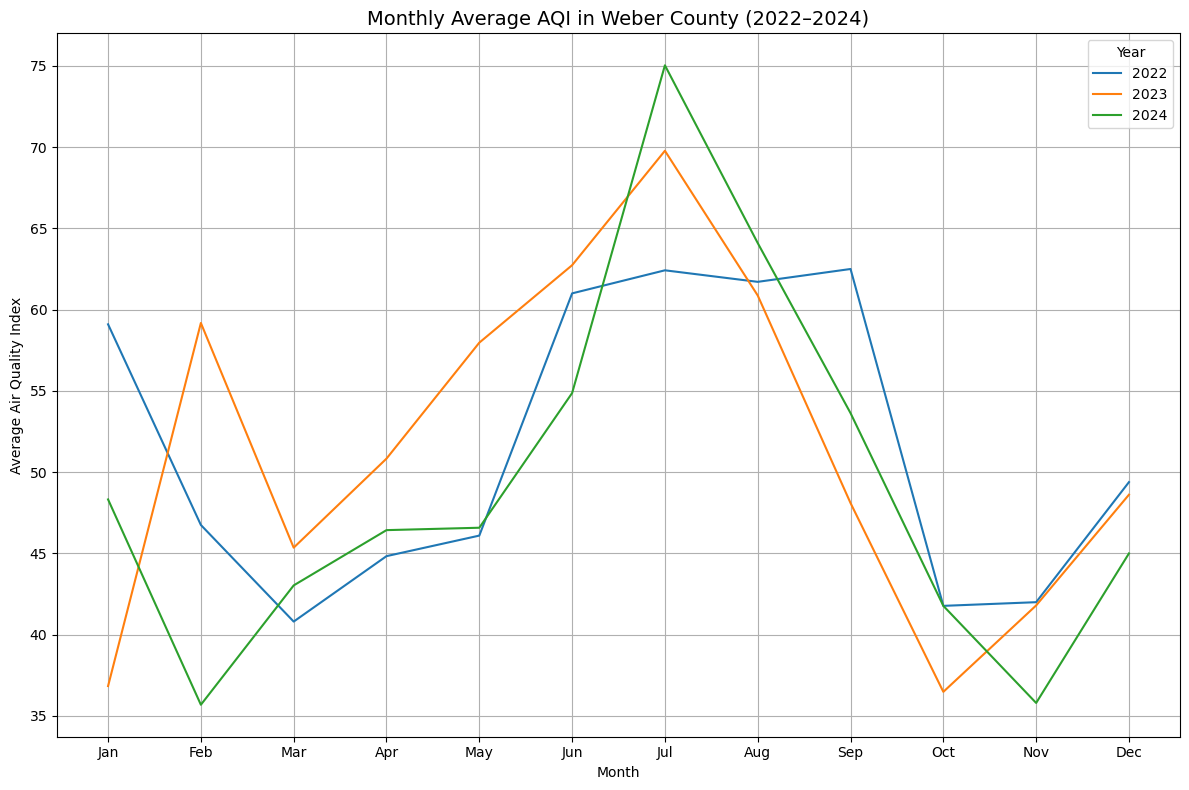

In [700]:
# Aggregate monthly mean AQI
df_2022_monthly = df_2022_vis.resample('ME').mean()
df_2023_monthly = df_2023_vis.resample('ME').mean()
df_2024_monthly = df_2024_vis.resample('ME').mean()

# Add 'Month' and 'Year' columns for plotting
df_2022_monthly['Month'] = df_2022_monthly.index.month
df_2022_monthly['Year'] = 2022

df_2023_monthly['Month'] = df_2023_monthly.index.month
df_2023_monthly['Year'] = 2023

df_2024_monthly['Month'] = df_2024_monthly.index.month
df_2024_monthly['Year'] = 2024

# Combine all years
df_all_monthly = pd.concat([df_2022_monthly, df_2023_monthly, df_2024_monthly])

# Plot monthly AQI trends
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_all_monthly, x='Month', y='AQI', hue='Year', palette=['#1f77b4', '#ff7f0e', '#2ca02c'])

plt.title('Monthly Average AQI in Weber County (2022–2024)', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Average Air Quality Index')
plt.xticks(ticks=np.arange(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                           'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year')
plt.grid(True)
plt.tight_layout()
plt.show()

Using the monthly average of the AQI shows a smoother line and a bigger picture view to how the data has changed over the years. However, it smoothed the line too much and it may not be able to capture short-term AQI fluctuations and changes. Smoothing out the graph also shows the very obvious point where we have a seasonal trend. The month July consistently jumps up in AQI.

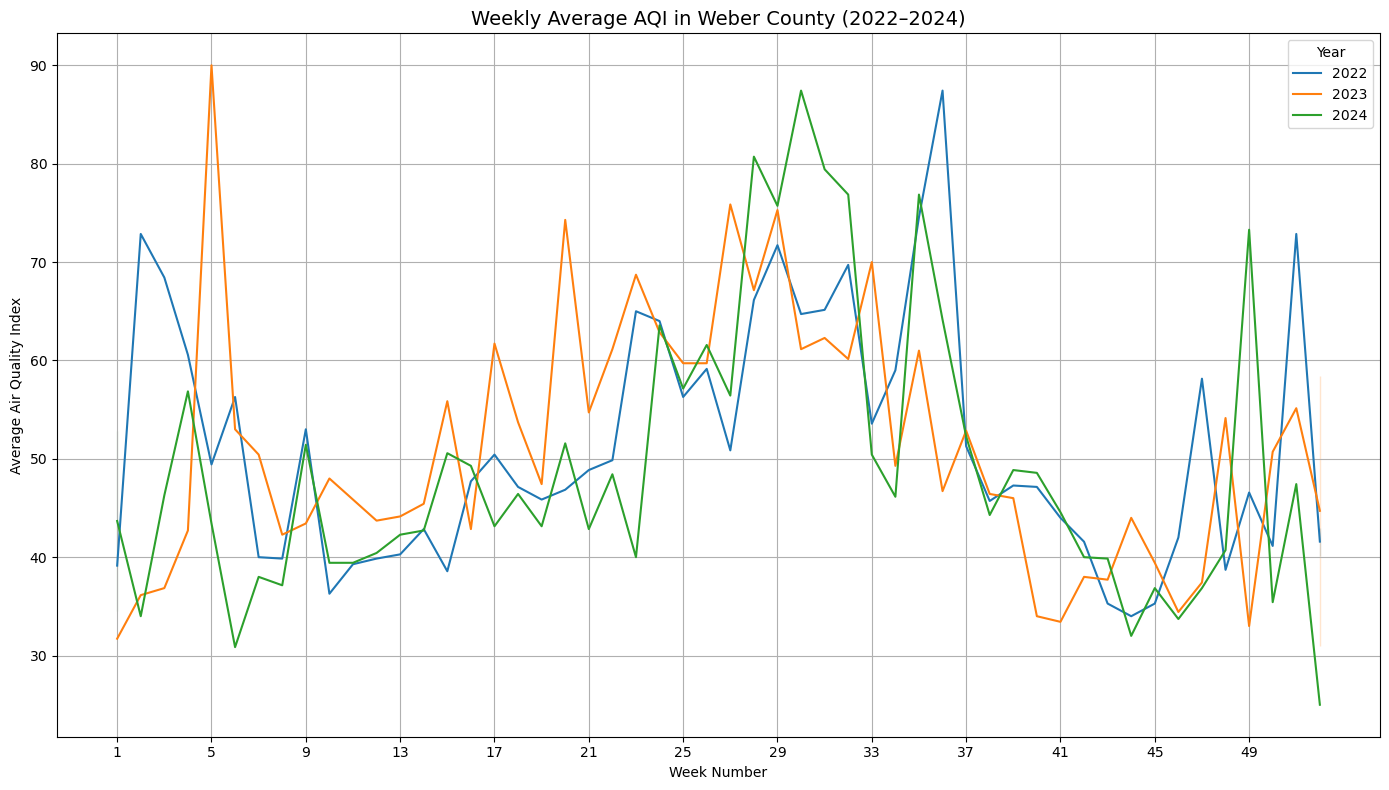

In [701]:
# Aggregate weekly mean AQI
df_2022_weekly = df_2022_vis.resample('W').mean()
df_2023_weekly = df_2023_vis.resample('W').mean()
df_2024_weekly = df_2024_vis.resample('W').mean()

# Add 'Week' and 'Year' columns for plotting
df_2022_weekly['Week'] = df_2022_weekly.index.isocalendar().week
df_2022_weekly['Year'] = 2022

df_2023_weekly['Week'] = df_2023_weekly.index.isocalendar().week
df_2023_weekly['Year'] = 2023

df_2024_weekly['Week'] = df_2024_weekly.index.isocalendar().week
df_2024_weekly['Year'] = 2024

# Combine all years
df_all_weekly = pd.concat([df_2022_weekly, df_2023_weekly, df_2024_weekly])
df_all_weekly.sort_values(['Year', 'Week'], inplace=True)

# Plot weekly AQI trends
plt.figure(figsize=(14, 8))
sns.lineplot(data=df_all_weekly, x='Week', y='AQI', hue='Year', palette=['#1f77b4', '#ff7f0e', '#2ca02c'])

plt.title('Weekly Average AQI in Weber County (2022–2024)', fontsize=14)
plt.xlabel('Week Number')
plt.ylabel('Average Air Quality Index')
plt.xticks(ticks=np.arange(1, 53, 4))  # Show every 4th week for readability
plt.legend(title='Year')
plt.grid(True)
plt.tight_layout()
plt.show()


Using a weekly average for AQI seems to be the most promising due to the available data, and the graph isn't so smoothed over like it was when using monthly average AQI. This seems to be a nice middleground between daily, and monthly AQI averaging.

##### Reason for Aggregation (if applicable):

Upon initial data exploration, while there is enough data for daily time series modeling, the distribution was skewed right, and the daily trends were quite jagged. So, when graphing both monthly, and weekly averages the monthly data looked a little to smooth, and weekly data looked to be the most promising since there are still obvious seasonly patterns and the data didn't look so smoothed over it wouldn't capture other trends.

So, in an attempt to capture as much AQI patterns as possible this weekly model will capture less noise than a daily one, and more detail than a monthly one.

The aggregation performed gathers the weekly AQI for each dataset, and uses that as the new time series column.

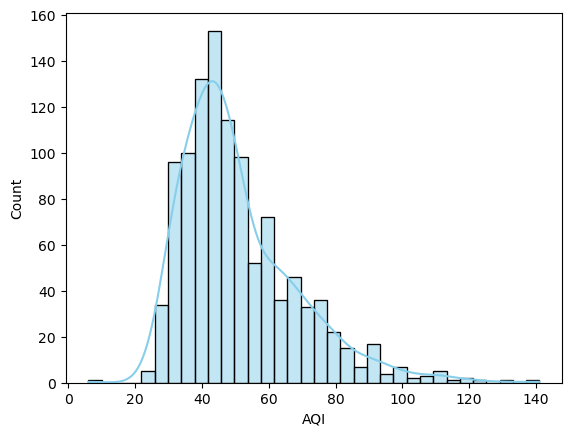

In [702]:
sns.histplot(df_vis_all['AQI'], kde=True, color='skyblue');


The daily AQI variance is a little skewed to the right, and so aggregation will be a good idea for making the variance more normal.

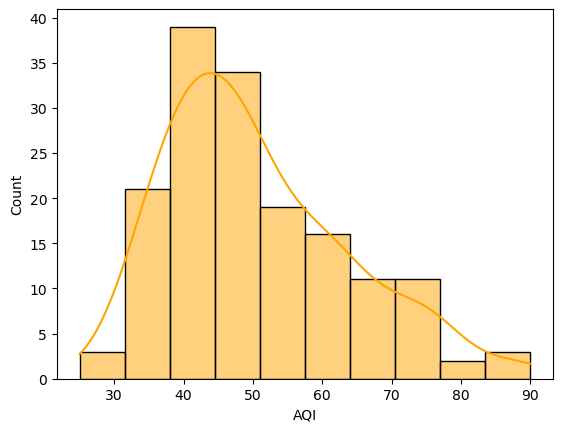

In [703]:
sns.histplot(df_all_weekly['AQI'], kde=True, color='orange');

The variance is not as prevalent, but still there, so we will move to log transformations to ensure the data is stationary.

In [704]:
df_all_weekly.head(5)

,AQI,Year,Week
Date,,,
2022-01-09,39.142857,2022,1
2022-01-16,72.857143,2022,2
2022-01-23,68.428571,2022,3
2022-01-30,60.571429,2022,4
2022-02-06,49.428571,2022,5


##### Transformations:

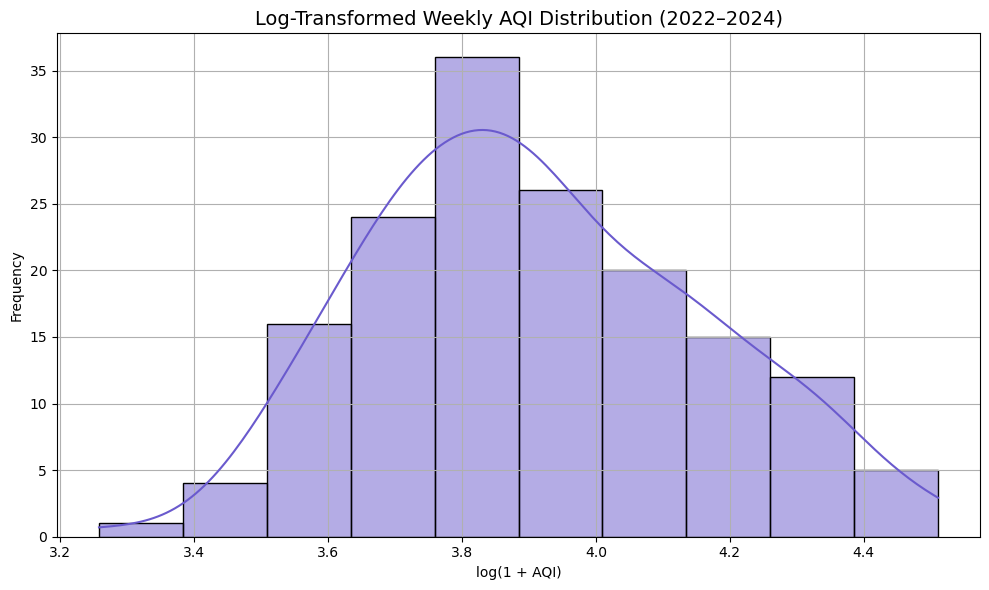

In [705]:
# df_all_weekly.sort_values(['Year', 'Week'], inplace=True)

# Step 1: Apply log transformation
df_all_weekly['AQI_log'] = np.log1p(df_all_weekly['AQI'])

# Step 2: Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_all_weekly['AQI_log'], kde=True, color='slateblue')
plt.title('Log-Transformed Weekly AQI Distribution (2022–2024)', fontsize=14)
plt.xlabel('log(1 + AQI)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


In [706]:
from statsmodels.tsa.stattools import adfuller

adfuller_result_weekly = adfuller(df_all_weekly['AQI_log'].dropna())
print("ADF Test - Weekly AQI AVG w/ Log Transformation")
print(f"ADF Statistic: {adfuller_result_weekly[0]}")
print(f"p-value: {adfuller_result_weekly[1]}")

ADF Test - Weekly AQI AVG w/ Log Transformation
ADF Statistic: -3.175036175461758
p-value: 0.0214759249555306


LOL I just did the log transform wrong...

##### Seasonal Patterns:

Well it passed after log transforming so we will still check for seasonality.

We first noticed of the seasonality of the data in the Daily AQI graph, and it was made clear there was seasonality when graphing the aggregated monthly avg AQI dataset. In order to get rid of this seasonality seasonl differencing will be needed to ensure this datat set is staionary and ready for modeling.

In [707]:
# # Seasonal differencing with a lag of 52 weeks
# df_all_weekly['AQI_log_seasonal_diff'] = df_all_weekly['AQI_log'] - df_all_weekly['AQI_log'].shift(52)

# result_seasonal_diff = adfuller(df_all_weekly['AQI_log_seasonal_diff'].dropna())
# print(f"ADF Statistic: {result_seasonal_diff[0]}")
# print(f"p-value: {result_seasonal_diff[1]}")

##### Autocorrelation:

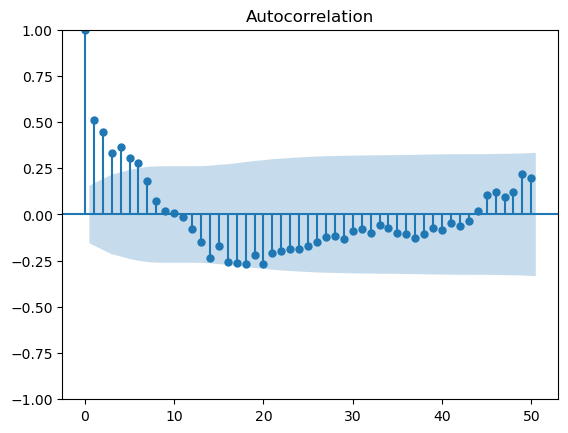

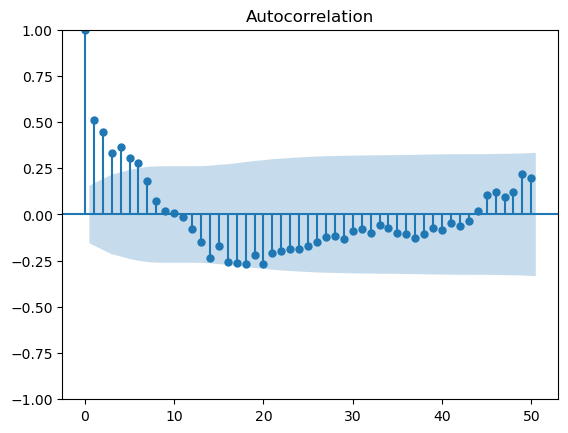

In [708]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_all_weekly['AQI_log'].dropna(), lags=50)


##### Correlation Coefficients:

In [709]:
# todo

##### Data Splitting:

In [710]:
# todo

##### Model Selection:

In [711]:
# todo

##### Model Parameters and Diagnostics:

In [712]:
# todo

##### Final Model Equation:

In [713]:
# todo

##### Forecasting:

In [714]:
# todo

##### Model Performance:

In [715]:
# todo

##### Conclusion:

In [716]:
# todo